In [1]:
import sys
sys.path.append('.')
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import torch
%matplotlib inline

## Train Data

In [2]:
train_df = pd.read_csv('csv/train.csv.gz', compression='gzip', header=0, sep=',', error_bad_lines=False, low_memory=False)
print('{0:,} registros a las {1}'.format(len(train_df), datetime.now()))
train_df.head()

180,761 registros a las 2020-10-03 18:52:22.757552


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,23364.0,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,10693.0,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,140.0,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,631.0,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,363.0,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días


In [5]:
no_conv, conv = train_df['conversion'].value_counts()
no_conv, conv

(164017, 16744)

In [6]:
no_conv/conv

9.79556856187291

In [49]:
train_df.isna().sum()

accepts_mercadopago                       0
available_quantity                        0
avg_gmv_item_domain_30days             3924
avg_gmv_item_sel                       3924
avg_gmv_seller_bday                    3924
avg_qty_orders_item_domain_30days      3924
avg_qty_orders_item_sel_30days         3924
avg_si_item_sel_30day                  3924
benefit                                   1
boosted                                   0
category_id                               0
conversion                                0
date                                      0
deal_print_id                             0
domain_id                                 0
etl_version                               0
free_shipping                             0
fulfillment                               0
full_name                                 0
health                                    0
is_pdp                                81266
product_id                           137862
item_id                         

In [50]:
train_df.dtypes

accepts_mercadopago                     bool
available_quantity                     int64
avg_gmv_item_domain_30days           float64
avg_gmv_item_sel                     float64
avg_gmv_seller_bday                  float64
avg_qty_orders_item_domain_30days    float64
avg_qty_orders_item_sel_30days       float64
avg_si_item_sel_30day                float64
benefit                              float64
boosted                                 bool
category_id                           object
conversion                              bool
date                                  object
deal_print_id                         object
domain_id                             object
etl_version                           object
free_shipping                           bool
fulfillment                             bool
full_name                             object
health                               float64
is_pdp                                object
product_id                           float64
item_id   

In [4]:
train_df['conversion'].value_counts()

False    164017
True      16744
Name: conversion, dtype: int64

In [25]:
for warranty in train_df['user_id'].unique()[:10]:
    print(warranty)

nan
151157147.0
498004001.0
32266680.0
206574359.0
519017590.0
553939382.0
15890414.0
486983278.0
19574642.0


In [20]:
len(train_df['main_picture'].unique()), len(train_df)

(24342, 180761)

In [2]:
isinstance(['hola'], list)

True

In [26]:
numerical_features = [
    'available_quantity',
    'avg_gmv_item_domain_30days',
    'avg_gmv_item_sel',
    'avg_gmv_seller_bday',
    'avg_qty_orders_item_domain_30days',
    'avg_qty_orders_item_sel_30days',
    'avg_si_item_sel_30day',
    'health',
    'offset',  
    'original_price',
    'price',
    'print_position',
    'qty_items_dom',
    'qty_items_sel',
    'sold_quantity',
    'total_asp_item_domain_30days',
    'total_asp_item_sel_30days',
    'total_gmv_domain_bday',
    'total_gmv_item_30days',
    'total_items_domain',
    'total_items_seller',
    'total_orders_domain_30days',
    'total_orders_item_30days',
    'total_orders_sel_30days',
    'total_si_domain_30days',
    'total_si_item_30days',
    'total_si_sel_30days',
    'total_visits_item',
    'total_visits_seller'
]

categorical_features = [
    # Booleans
    'accepts_mercadopago',
    'boosted',
    'free_shipping',
    'is_pdp',
    
    # Categoricals
    'category_id',
    'deal_print_id',
    'domain_id',
    'product_id',
    'item_id',
    'listing_type_id',
    'logistic_type',
    'platform',
    'site_id',
    'tags',
    'uid',
    'user_id',
    'warranty',
    'main_picture',
    'print_server_timestamp'
]

date_features = [
    'date'
]

trash_features = [
    'print_server_timestamp'
    'main_picture',
    'title'
]

In [42]:
train_df[train_df['warranty'].str.contains(pat='sin|Sin', na=False)]['warranty']

19        Sin garantía
22        Sin garantía
28        Sin garantía
29        Sin garantía
30        Sin garantía
              ...     
180735    Sin garantía
180737    Sin garantía
180746    Sin garantía
180749    Sin garantía
180759    Sin garantía
Name: warranty, Length: 21986, dtype: object

In [51]:
[item if 'SIN GARAN' in str(item).upper() else False for item in train_df['warranty'].values][:10]

[False, False, False, False, False, False, False, False, False, False]

### Discount

In [11]:
train_df['original_price'].describe([.25,.5,.75,.8,.9,.95,.99])

count    180761.000000
mean       5468.021941
std       12544.078620
min          30.000000
25%         895.000000
50%        1890.000000
75%        3999.000000
80%        4877.000000
90%       12999.000000
95%       25999.000000
99%       59718.000000
max      499000.000000
Name: original_price, dtype: float64

In [12]:
train_df['price'].describe([.25,.5,.75,.8,.9,.95,.99])

count    180761.000000
mean       4044.029132
std        9007.786163
min          24.000000
25%         745.000000
50%        1454.000000
75%        2998.000000
80%        3499.000000
90%        9699.000000
95%       19999.000000
99%       38999.000000
max      449100.000000
Name: price, dtype: float64

In [10]:
train_df['discount'] = train_df['original_price'] - train_df['price']
train_df['discount'].describe([.25,.5,.75,.8,.9,.95,.99])

count    180761.000000
mean       1423.992808
std        4445.021240
min           2.000000
25%         105.000000
50%         316.000000
75%        1045.000000
80%        1380.000000
90%        3000.000000
95%        6000.000000
99%       17600.000000
max      346500.000000
Name: discount, dtype: float64

### Vstack

In [17]:
a = np.array([1,2,3,4,5])
b = np.array([4,2,6,1,9])
c = np.vstack((a,b))
c

array([[1, 2, 3, 4, 5],
       [4, 2, 6, 1, 9]])

In [18]:
f1 = c[0,:]
f1

array([1, 2, 3, 4, 5])

In [19]:
f2 = c[1,:]
f2

array([4, 2, 6, 1, 9])

In [23]:
f1 / f2, type(f1 / f2), (f1 / f2).dtype

(array([0.25      , 1.        , 0.5       , 4.        , 0.55555556]),
 numpy.ndarray,
 dtype('float64'))

### Tags

In [35]:
train_df['warranty'].values[:100]

array(['Garantía de fábrica: 12 meses', nan, nan,
       'Garantía de fábrica: 90 días', 'Garantía del vendedor: 90 días',
       '6 meses de garantía.', 'Garantía de fábrica: 2 meses',
       'Garantía de fábrica: 6 meses', 'Garantía de fábrica: 30 días',
       '12 MESES de garantia, exclusiva del fabricante por fallas de fabrica.',
       '12 meses', 'Garantía de fábrica: 12 meses', nan,
       'Garantía de fábrica: 6 meses', nan,
       'GARANTIA DEL FABRICANTE 12 MESES', nan,
       'Garantía de fábrica: 30 días', nan, 'Sin garantía',
       'Garantía del vendedor: 15 días', nan, 'Sin garantía', nan,
       'Garantía del vendedor: 180 días', 'Garantía de fábrica: 60 días',
       'Garantía del vendedor: 90 días', 'Garantía del vendedor: 6 meses',
       'Sin garantía', 'Sin garantía', 'Sin garantía',
       'Garantía del vendedor: 1 años', 'Sin garantía', nan,
       'Sin garantía', nan, 'Sin garantía', 'Sin garantía',
       'Sin garantía', 'Garantía de fábrica: 12 meses',
      

In [5]:
def transform_tags(feature:np.ndarray) -> np.ndarray:
    tms_1 = [value[1:-1] for value in feature]
    tms_2 = [sorted(value.split(', ')) for value in tms_1]
    tms_3 = [' '.join(value) for value in tms_2]
    return np.array(tms_3, dtype=object)

In [6]:
new_feature_train = transform_tags(train_df['tags'].to_numpy())

In [7]:
len(np.unique(new_feature_train))

316

In [ ]:
np.unique(new_feature_train)

### Dates

In [9]:
train_df['date'].to_numpy()

array(['2020-03-06', '2020-04-01', '2020-04-08', ..., '2020-03-01',
       '2020-04-10', '2020-04-11'], dtype=object)

In [10]:
def decompose_print_date(features:np.ndarray) -> np.ndarray:
    print_date_feature = features[0]
    dates = [datetime.strptime(str_date, '%Y-%m-%d') for str_date in print_date_feature]
    date_parts = np.array([[dt.year, dt.month, dt.day, dt.weekday()+1, 1 if dt.weekday() >= 0 and dt.weekday() <= 4 else 0] for dt in dates], dtype=np.int32)
    return date_parts[:,0], date_parts[:,1], date_parts[:,2], date_parts[:,3], date_parts[:,4]

In [11]:
year_feature, month_feature, day_feature, day_of_week_feature, is_weekend_feature = FeatureExtractor(decompose_print_date).transform([train_df['date'].to_numpy()])

In [12]:
np.unique(year_feature, return_counts=True)

(array([2020], dtype=int32), array([180761]))

In [13]:
np.unique(month_feature, return_counts=True)

(array([3, 4], dtype=int32), array([ 78203, 102558]))

In [14]:
np.unique(day_feature, return_counts=True)

(array([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18, 20,
        21, 22, 23, 24, 25, 26, 27, 31], dtype=int32),
 array([ 8268,  9013,  8454,  8332,  3989,  3707,  8445,  8277, 13974,
         8043,  9816, 16425,  5089,  4204,  5646,  4726, 12088,  4821,
         3707,  3027,  3084, 18271,  3412,  4035,  1908]))

In [15]:
np.unique(day_of_week_feature, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([35819, 20668, 20680, 16108, 24941, 36458, 26087]))

In [16]:
np.unique(is_weekend_feature, return_counts=True)

(array([0, 1], dtype=int32), array([ 62545, 118216]))

## EDA

In [17]:
data = []
for column in numerical_features:
    df = pd.DataFrame(train_df[column].describe([.25,.5,.75,.8,.9,.95,.99])).T
    df.insert(0, 'feature', column)
    data.append(df)

pd.concat(data, ignore_index=True).set_index('feature').style.format("{:,.0f}", na_rep="")

,count,mean,std,min,25%,50%,75%,80%,90%,95%,99%,max
feature,,,,,,,,,,,,
available_quantity,"180,761","2,075","11,235",0,18,67,366,597,"1,744","5,998","99,039","99,999"
avg_gmv_item_domain_30days,"176,837",331,487,5,86,169,316,403,786,"1,345","2,604","3,778"
avg_gmv_item_sel,"176,837","1,122","4,048",5,144,263,677,852,"2,226","3,563","14,075","57,283"
avg_gmv_seller_bday,"176,837","10,842","26,544",1,798,"2,773","9,314","12,231","22,535","41,477","159,970","244,988"
avg_qty_orders_item_domain_30days,"176,837",4,3,1,3,4,5,5,7,9,16,38
avg_qty_orders_item_sel_30days,"176,837",13,25,1,4,7,13,15,23,38,170,258
avg_si_item_sel_30day,"176,837",18,33,1,5,9,19,21,33,52,190,466
health,"180,761",1,0,0,1,1,1,1,1,1,1,1
offset,"180,761",245,570,0,0,96,288,336,624,960,"2,448","9,984"


In [18]:
train_df[numerical_features].isna().sum()

available_quantity                      0
avg_gmv_item_domain_30days           3924
avg_gmv_item_sel                     3924
avg_gmv_seller_bday                  3924
avg_qty_orders_item_domain_30days    3924
avg_qty_orders_item_sel_30days       3924
avg_si_item_sel_30day                3924
health                                  0
offset                                  0
original_price                          0
price                                   0
print_position                          0
qty_items_dom                        3924
qty_items_sel                        3924
sold_quantity                           0
total_asp_item_domain_30days         3924
total_asp_item_sel_30days            3924
total_gmv_domain_bday                3924
total_gmv_item_30days                3924
total_items_domain                      0
total_items_seller                      0
total_orders_domain_30days           3924
total_orders_item_30days             3924
total_orders_sel_30days           

In [19]:
train_df[train_df['avg_gmv_item_domain_30days'].isna()].head(3)

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty
80,True,931,NaN,NaN,NaN,NaN,NaN,NaN,0.001,False,...,NaN,NaN,NaN,NaN,83887,321,36382,340b7d69-ee64-4dba-99c7-03066dbcb5f3,436633616.0,Garantía del vendedor: 30 días
89,True,1000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,False,...,NaN,NaN,NaN,NaN,80838,19,6089,60f2a17a-5f37-4238-9b68-85c250bed879,83963350.0,Garantía del vendedor: 6 meses
93,True,965,NaN,NaN,NaN,NaN,NaN,NaN,0.000,False,...,NaN,NaN,NaN,NaN,7997283,661,176129,028c9df1-483a-451f-b206-59d2b3aca377,87061384.0,NaN


In [20]:
data = []
total_samples = len(train_df)
for column in categorical_features:
    data.append({
        'feature' : column,
        'total_samples' : total_samples,
        'unique_values' : len(train_df[column].unique()),
        'values' : np.nan if len(train_df[column].unique()) > 10 else train_df[column].unique()
        
    })
    
pd.DataFrame(data)

,feature,total_samples,unique_values,values
0,accepts_mercadopago,180761,1,[True]
1,boosted,180761,1,[False]
2,free_shipping,180761,2,"[True, False]"
3,is_pdp,180761,3,"[False, nan, True]"
4,category_id,180761,2198,NaN
5,deal_print_id,180761,177948,NaN
6,domain_id,180761,1693,NaN
7,product_id,180761,4079,NaN
8,item_id,180761,24962,NaN
9,listing_type_id,180761,2,"[gold_special, gold_pro]"


In [103]:
len(train_df['offset'].unique()), len(train_df['print_position'].unique())

(208, 10633)

In [22]:
train_df[train_df['is_pdp'].isna()][categorical_features].head(3)

,accepts_mercadopago,boosted,free_shipping,is_pdp,category_id,deal_print_id,domain_id,product_id,item_id,listing_type_id,logistic_type,platform,site_id,tags,uid,user_id,warranty
6,True,False,False,NaN,MLA3551,e9836a70-8762-11ea-ab2d-9588ee58d303,MLA-SUPPLEMENTS,14012093.0,MLA704665426,gold_special,cross_docking,/web/desktop,MLA,"[good_quality_picture, good_quality_thumbnail,...",c6874fdd-aabd-495a-9632-b651b0ffac87,32266680.0,Garantía de fábrica: 2 meses
8,True,False,False,NaN,MLA11236,cc407620-86e9-11ea-9076-139c55b6e72a,MLA-PLAYGROUND_SWING_SETS,NaN,MLA822540433,gold_special,fulfillment,/mobile/android,MLA,"[loyalty_discount_eligible, brand_verified, go...",67b5ca7d-32a2-4415-9594-d0afe6dd1c26,206574359.0,Garantía de fábrica: 30 días
10,True,False,True,NaN,MLA5420,d25c3c70-79f5-11ea-b6b9-bb25c7003502,MLA-THERMOMETERS,NaN,MLA728471627,gold_pro,cross_docking,/web/mobile,MLA,"[brand_verified, deal_of_the_day, loyalty_disc...",81f99b91-2df0-4cfc-9b44-671e468dc7f6,NaN,12 meses


In [57]:
correlations_df = train_df[numerical_features].corr()\
    .reset_index()\
    .melt(id_vars=['index'], value_vars=numerical_features)\
    .rename(columns={'index':'feature_1', 'variable':'feature_2', 'value':'correlation'})
correlations_df.head()

,feature_1,feature_2,correlation
0,available_quantity,available_quantity,1.000000
1,avg_gmv_item_domain_30days,available_quantity,-0.030466
2,avg_gmv_item_sel,available_quantity,-0.027117
3,avg_gmv_seller_bday,available_quantity,-0.042194
4,avg_qty_orders_item_domain_30days,available_quantity,0.075127


In [6]:
correlations_df['correlation'].describe()

count    841.000000
mean       0.162699
std        0.286833
min       -0.284704
25%       -0.026080
50%        0.065163
75%        0.244988
max        1.000000
Name: correlation, dtype: float64

In [58]:
important_correlations_df = correlations_df[(correlations_df['correlation'] != 1) & (correlations_df['correlation'] >= .65)]\
    .sort_values(['feature_1', 'feature_2'], ascending=[True, True])\
    .drop_duplicates('correlation', 'first')

In [59]:
print(len(important_correlations_df))
important_correlations_df

25


,feature_1,feature_2,correlation
262,avg_gmv_item_domain_30days,original_price,0.654553
291,avg_gmv_item_domain_30days,price,0.699526
436,avg_gmv_item_domain_30days,total_asp_item_domain_30days,0.856978
524,avg_gmv_item_sel,total_gmv_item_30days,0.652248
670,avg_gmv_seller_bday,total_orders_sel_30days,0.790084
179,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,0.926570
299,original_price,price,0.967906
444,original_price,total_asp_item_domain_30days,0.751698
473,original_price,total_asp_item_sel_30days,0.673203
445,price,total_asp_item_domain_30days,0.783813


In [11]:
correlations_df[
    (correlations_df['correlation'] != 1) & 
    (
        (correlations_df['feature_1'].str.startswith('total')) | 
        (correlations_df['feature_1'].str.startswith('qty'))
    )
].sort_values('correlation', ascending=False).head(20)

,feature_1,feature_2,correlation
367,total_items_domain,qty_items_dom,0.940498
563,qty_items_dom,total_items_domain,0.940498
777,total_orders_sel_30days,total_si_sel_30days,0.932699
693,total_si_sel_30days,total_orders_sel_30days,0.932699
621,qty_items_dom,total_orders_domain_30days,0.918120
369,total_orders_domain_30days,qty_items_dom,0.918120
397,total_items_seller,qty_items_sel,0.914234
593,qty_items_sel,total_items_seller,0.914234
44,total_asp_item_domain_30days,avg_gmv_item_domain_30days,0.856978
832,total_items_seller,total_visits_seller,0.817764


In [69]:
correlations_df[(correlations_df['feature_1'] == 'sold_quantity') & (correlations_df['correlation'] >= .65)]

,feature_1,feature_2,correlation
420,sold_quantity,sold_quantity,1.0


In [28]:
numeric_features_selected = [
    {
        'keep' : ['total_asp_item_domain_30days'],
        'remove' : ['avg_gmv_item_domain_30days', 'original_price', 'price']
    },
    {
        'keep' : ['total_orders_sel_30days'],
        'remove' : ['avg_gmv_seller_bday', 'total_si_sel_30days', 'total_visits_seller', 'qty_items_sel']
    },
    {
        'keep' : ['total_orders_domain_30days'],
        'remove' : ['qty_items_dom', 'total_items_domain', 'total_si_domain_30days']
    },
    {
        'keep' : ['avg_qty_orders_item_sel_30days'],
        'remove' : ['avg_si_item_sel_30day']
    },
    {
        'keep' : ['total_orders_item_30days'],
        'remove' : ['total_si_item_30days', 'total_visits_item']
    },
    {
        'keep' : ['total_items_seller'],
        'remove' : ['qty_items_sel', 'total_visits_seller']
    },
]

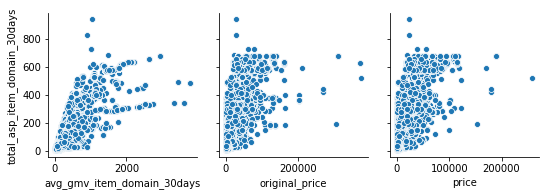

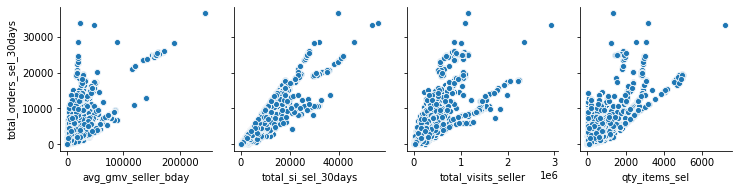

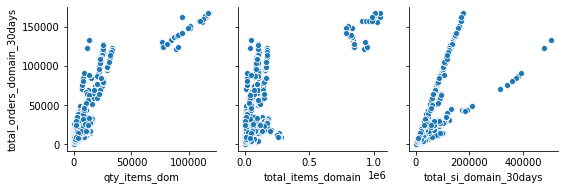

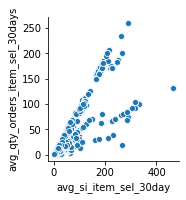

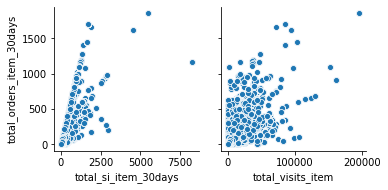

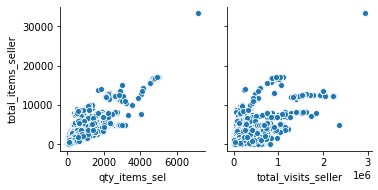

In [29]:
for entry in numeric_features_selected:
    keep, remove = list(entry.values())
    sns.pairplot(train_df, y_vars=keep, x_vars=remove)

In [30]:
len(train_df['tags'].unique())

1203

In [31]:
train_df['tags'].value_counts()

[brand_verified, good_quality_picture, good_quality_thumbnail, loyalty_discount_eligible, immediate_payment, cart_eligible]                                                                                                    26863
[brand_verified, good_quality_picture, good_quality_thumbnail, loyalty_discount_eligible, today_promotion, immediate_payment, cart_eligible]                                                                                   24314
[today_promotion, brand_verified, good_quality_picture, good_quality_thumbnail, loyalty_discount_eligible, immediate_payment, cart_eligible]                                                                                    6280
[loyalty_discount_eligible, today_promotion, brand_verified, good_quality_picture, good_quality_thumbnail, immediate_payment, cart_eligible]                                                                                    6135
[good_quality_thumbnail, loyalty_discount_eligible, today_promotion, brand_verified,

## Test Data

In [53]:
test_df = pd.read_csv('csv/test.csv', sep=',', low_memory=False)
print('{0:,} registros a las {1}'.format(len(test_df), datetime.now()))
test_df.head()

19,211 registros a las 2020-09-20 21:36:07.454254


,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,4,98.426510,91.979648,3657.724000,3.589443,3.461023,4.988265,0.001,False,...,1364.0,18.0,5951.0,40954,300,100477,703f4bd1-cc3e-4102-8cfa-fe3cdd15ebb7,233223201.0,Garantia de fabrica,0
1,True,12,242.485208,821.376944,985.652333,3.215580,26.222222,28.388889,0.001,False,...,3724.0,41.0,1022.0,135133,926,44033,d714e65e-5447-4f7d-9a4e-aaa57efa6107,337881137.0,NaN,1
2,True,5,2450.533424,1365.504354,33454.856667,7.097276,14.646259,15.217687,0.001,False,...,1839.0,71.0,11185.0,204788,8457,716157,299cb623-b71c-4f9d-b792-48d5744f0449,86609353.0,Garantía de fábrica: 12 meses,2
3,True,9052,157.735448,78.692131,160.007333,4.927390,2.983607,3.524590,0.001,False,...,85528.0,44.0,215.0,1404477,1907,6580,f2060244-f0da-43db-91b7-4c1bb5f99e67,430797570.0,Sin garantía,3
4,True,37,116.891454,163.245653,4043.050667,2.937837,7.257066,19.771198,0.001,False,...,61466.0,274.0,14690.0,1466424,2633,215184,d7f3b7f4-a9fa-4bd8-a600-3f2714480779,6566243.0,Garantía de fábrica: 6 meses,4


In [34]:
new_feature_test = transform_tags(test_df['tags'].to_numpy())
new_feature_test

array(['brand_verified cart_eligible good_quality_picture immediate_payment loyalty_discount_eligible',
       'brand_verified good_quality_picture good_quality_thumbnail immediate_payment loyalty_discount_eligible today_promotion',
       'brand_verified good_quality_picture good_quality_thumbnail immediate_payment loyalty_discount_eligible',
       ...,
       'brand_verified cart_eligible good_quality_picture good_quality_thumbnail immediate_payment loyalty_discount_eligible today_promotion',
       'cart_eligible good_quality_picture good_quality_thumbnail immediate_payment loyalty_discount_eligible',
       'brand_verified cart_eligible good_quality_picture good_quality_thumbnail immediate_payment loyalty_discount_eligible today_promotion'],
      dtype=object)

In [35]:
len(np.unique(new_feature_test)), len(np.unique(new_feature_train))

(129, 316)

In [64]:
data = []
total_samples = len(test_df)
for column in categorical_features:
    data.append({
        'feature' : column,
        'total_samples' : total_samples,
        'unique_values' : len(test_df[column].unique()),
        'values' : np.nan if len(test_df[column].unique()) > 10 else test_df[column].unique()
        
    })
    
pd.DataFrame(data)

,feature,total_samples,unique_values,values
0,accepts_mercadopago,19211,1,[True]
1,boosted,19211,1,[False]
2,free_shipping,19211,2,"[False, True]"
3,is_pdp,19211,3,"[False, nan, True]"
4,category_id,19211,880,NaN
5,deal_print_id,19211,19057,NaN
6,domain_id,19211,744,NaN
7,product_id,19211,611,NaN
8,item_id,19211,2733,NaN
9,listing_type_id,19211,2,"[gold_special, gold_pro]"


In [48]:
np.unique(day_of_week_feature, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([3857, 2016, 2258, 1714, 2678, 3904, 2784]))

In [49]:
np.unique(is_weekend_feature, return_counts=True)

(array([0, 1], dtype=int32), array([ 6688, 12523]))

In [54]:
test_df.isna().sum()

accepts_mercadopago                      0
available_quantity                       0
avg_gmv_item_domain_30days             441
avg_gmv_item_sel                       441
avg_gmv_seller_bday                    441
avg_qty_orders_item_domain_30days      441
avg_qty_orders_item_sel_30days         441
avg_si_item_sel_30day                  441
benefit                                  0
boosted                                  0
category_id                              0
date                                     0
deal_print_id                            0
domain_id                                0
etl_version                              0
free_shipping                            0
fulfillment                              0
full_name                                0
health                                   0
is_pdp                                8918
product_id                           14500
item_id                                  0
listing_type_id                          0
logistic_ty

In [55]:
columns = ['listing_type_id', 'logistic_type', 'platform']
for column in columns:
    print('TRAIN')
    print(train_df[column].unique())
    print('TEST')
    print(test_df[column].unique())

TRAIN
['gold_special' 'gold_pro']
TEST
['gold_special' 'gold_pro']
TRAIN
['cross_docking' 'drop_off' 'fulfillment' 'xd_drop_off' 'not_specified'
 'custom' 'default']
TEST
['cross_docking' 'fulfillment' 'drop_off' 'xd_drop_off' 'custom'
 'not_specified']
TRAIN
['/web/desktop' '/mobile/android' '/web/mobile' '/mobile/ios']
TEST
['/mobile/android' '/web/desktop' '/web/mobile' '/mobile/ios']
